In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns

In [2]:
x_original=pd.read_csv('../XLable_onlyDiabeticRemoved.txt')
y_original=pd.read_csv('../TargetLable_onlyDiabeticRemoved.txt')

# x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
# y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

y_original=y_original[['Unnamed: 0','S000300']]

In [3]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
 
#combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
data=data.drop(columns=['FIELD_6','FIELD_7','B_DAY'])
print(data.shape)

(185843, 407)


In [4]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia

print(data.shape)

(169024, 407)


In [5]:
mydata=data[['S000300_y','S000300_x', 'L103300', 'S000501', 'L100700', 'SEX', 'L103100', 'L190300', 'L190400', 
             'L101300', 'S000502', ]].dropna() 

print(mydata.shape)

mydata.head()

(136533, 11)


,S000300_y,S000300_x,L103300,S000501,L100700,SEX,L103100,L190300,L190400,L101300,S000502
0,19.7,20.1,3.1,121.0,3.0,1.0,68.0,4.20,12.3,8.0,67.0
1,20.2,19.7,3.3,117.0,3.0,1.0,71.0,4.24,13.1,9.0,76.0
2,21.0,20.2,3.4,135.0,3.8,1.0,72.0,4.26,12.9,10.0,82.0
3,24.8,24.7,3.1,112.0,4.1,1.0,51.0,4.20,13.2,20.0,70.0
4,25.5,24.8,2.8,118.0,3.7,1.0,64.0,4.20,13.5,12.0,71.0


In [6]:
x=mydata[['S000300_x', 'L103300', 'S000501', 'L100700', 'SEX', 'L103100', 'L190300', 'L190400', 
             'L101300', 'S000502']] 

# x=mydata.iloc[:,1:]
y=mydata[['S000300_y']]

In [7]:
xtrain,xtest,ytrain,ytest=train_test_split(x, y, random_state=42, test_size=0.2)

In [8]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[9.58246226e-01 5.76535861e-04 4.18455858e-03 9.71977660e-03
 1.02521700e-05 5.49845980e-04 3.49081217e-03 2.74443675e-04
 3.73717836e-03 1.92103704e-02]


In [9]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred 
ypredPD.tail(10)

mean_squared_error 0.9847006564433041
root mean_squared_error 0.9923208434993714
mean_absolute_error 0.675404631776444
r2_score 0.9064045137185275


,t + 1,pred (t +1)
27297,19.6,20.099920
27298,21.7,21.710150
27299,26.4,25.649556
27300,21.1,20.331813
27301,24.8,25.155574
27302,25.9,25.185266
27303,25.0,24.576481
27304,24.8,24.574908
27305,23.4,21.503866
27306,21.7,21.080309


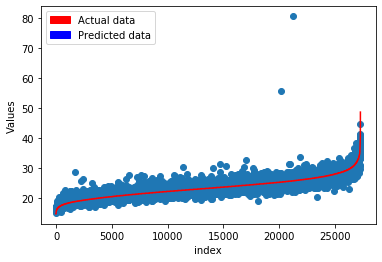

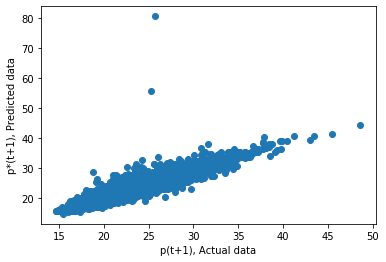

In [10]:
import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])


In [11]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

XGBRegressor(alpha=200, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=10,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [12]:
ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


mean_squared_error 1.100176903238949
root mean_squared_error 1.0488931800898265
mean_absolute_error 0.7646877786417937
r2_score 0.895428532945004


In [13]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)


mean_squared_error 1.100176903238949
root mean_squared_error 1.0488931800898265
mean_absolute_error 0.7646877786417937
r2_score 0.895428532945004


,t + 1,pred (t +1)
0,26.3,25.765114
1,22.9,22.325386
2,23.0,22.373842
3,24.3,23.328014
4,18.6,18.886978
5,26.0,24.446329
6,23.6,23.318645
7,23.1,23.743721
8,21.6,21.165031
9,24.8,23.843136


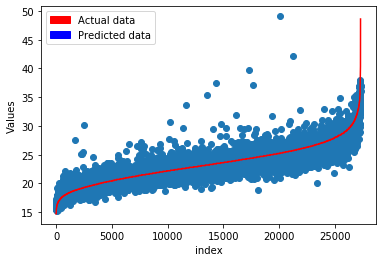

,t + 1,pred (t +1)
21304,14.7,15.488611
21584,14.7,15.510023
6250,14.8,15.540064
16734,14.9,15.854152
6873,14.9,15.836420
7695,14.9,16.532728
26515,15.0,15.494056
9910,15.1,16.532200
269,15.1,15.947185
23666,15.1,15.540338


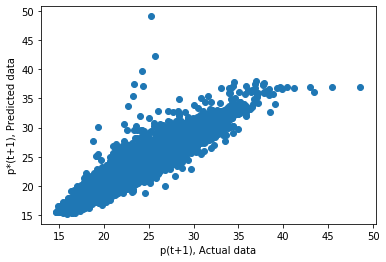

In [14]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)